<img src="images/ProjectPythia_Logo_Final-01-Blue.svg" width=250 alt="Project Pythia Logo"></img> 

# Remote Data Access with Xarray

---

## Overview
This Project Pythia Cookbook will cover working with Xarray to access data from NCEP/DOE Reanalysis II utilizing OPeNDAP. This workflow can be applied to most data with an OPeNDAP Dataset Access Form URL. For this introduction, we will be making a plot of 500 mb Geopotential Height contours over the continental United States (CONUS).

In this notebook, you will learn to:

1. Utilize Xarray and OPeNDAP to open NCEP/DOE Reanalysis II data.
1. Subset data 
1. Adjust coordinate/dimensions/variable names
1. Creating a plot

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Introduction to Xarray](https://foundations.projectpythia.org/core/xarray/xarray-intro.html) | Required | |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) |Helpful| 
| [Matplotlib Basics](https://foundations.projectpythia.org/core/matplotlib/matplotlib-basics.html) |Helpful| 

- **Time to learn**: 60 minutes. 

---

## Imports

In [3]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndimage #smooths contours
import xarray as xr

## Obtaining Data

The full NCEP/DOE Reanalysis II Dataset is hosted [here](https://psl.noaa.gov/data/gridded/data.ncep.reanalysis2.html). Each variable in the dataset can be accessed from the THREDDS Data Server (TDS), a file download, or through an interactive web tool within the website. For this cookbook, we will be utilizing the OPeNDAP URL on the TDS. <br>

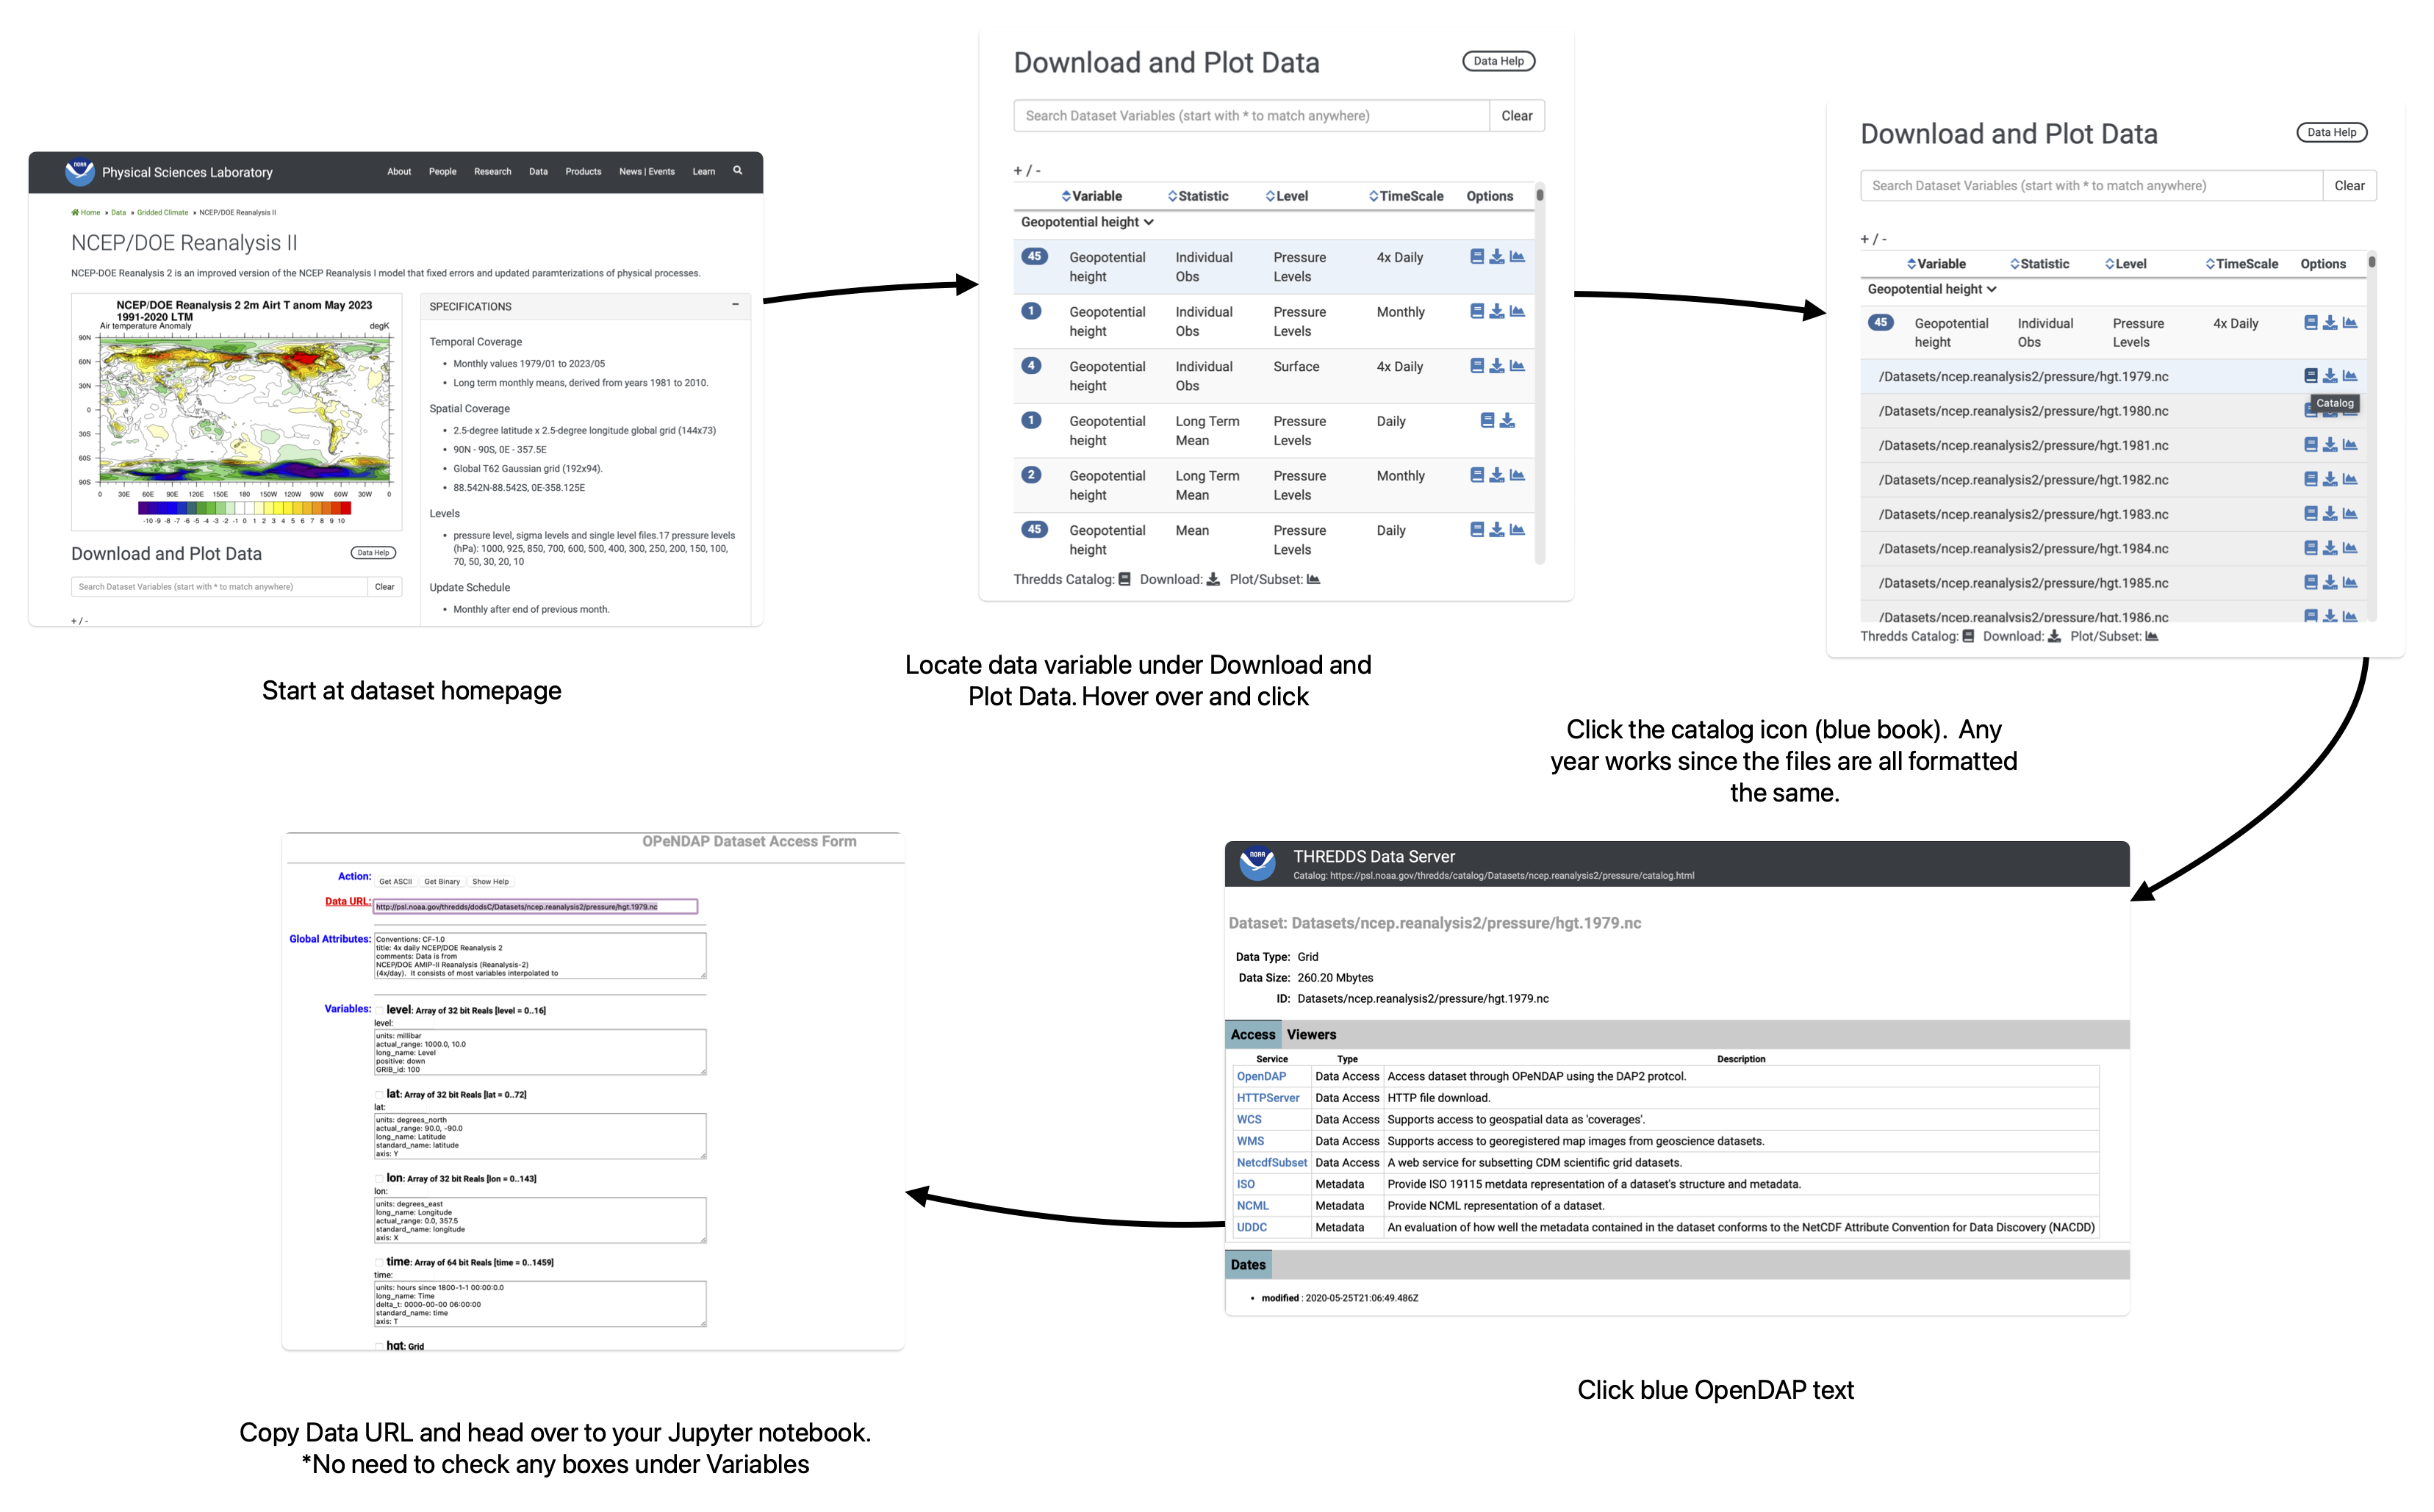

## Opening Data 

Reanalysis II data contains data subset by year (1979 - present) and long term mean (1981 - 2010). By simply copying and pasting the Data URL from the OPeNDAP Data Access Form, the dataset can be opened with `xr.open_dataset`. 
<br>
If you need a refresher on the terminology used in the `xarray.Dataset` output below, the [Xarray documention](https://docs.xarray.dev/en/stable/user-guide/terminology.html) has a section describing it.

Now that we have our data URL, let's open it with `xr.open_dataset`. We will start with opening the original URL, then we will step through some small changes to make the URL applicable for multiple datasets.

In [4]:
data_a = xr.open_dataset('http://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis2/pressure/hgt.2016.nc')
data_a

<xarray.Dataset>
Dimensions:  (level: 17, lat: 73, lon: 144, time: 1464)
Coordinates:
  * level    (level) float32 1e+03 925.0 850.0 700.0 ... 50.0 30.0 20.0 10.0
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 2016-01-01 ... 2016-12-31T18:00:00
Data variables:
    hgt      (time, level, lat, lon) float32 ...
Attributes:
    Conventions:                     CF-1.0
    title:                           4x daily NCEP/DOE Reanalysis 2
    comments:                        Data is from \nNCEP/DOE AMIP-II Reanalys...
    platform:                        Model
    source:                          NCEP/DOE AMIP-II Reanalysis (Reanalysis-...
    institution:                     National Centers for Environmental Predi...
    dataset_title:                   NCEP-DOE AMIP-II Reanalysis
    References:                      https://www.psl.noaa.gov/data/gridded/da...
    source_url:                      http://www.cpc.ncep.noaa.gov/products/we...
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    history:                         created 2016/07 by NOAA/ESRL/PSD\nConver...
    DODS_EXTRA.Unlimited_Dimension:  time

This method works for any OPeNDAP URL, but it can be time consuming if you want to look at several different years for the same dataset. By editing the URL to include an f string, we can easily grab a different year in the same dataset without changing the URL every time. When looking at the outputs for data_a and data_b, they are identical.

In [5]:
# Specify year 
year = 2016

# Construct our OPeNDAP access URL
data_b = xr.open_dataset(f'http://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis2/pressure/hgt.{year}.nc')
data_b

<xarray.Dataset>
Dimensions:  (level: 17, lat: 73, lon: 144, time: 1464)
Coordinates:
  * level    (level) float32 1e+03 925.0 850.0 700.0 ... 50.0 30.0 20.0 10.0
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 2016-01-01 ... 2016-12-31T18:00:00
Data variables:
    hgt      (time, level, lat, lon) float32 ...
Attributes:
    Conventions:                     CF-1.0
    title:                           4x daily NCEP/DOE Reanalysis 2
    comments:                        Data is from \nNCEP/DOE AMIP-II Reanalys...
    platform:                        Model
    source:                          NCEP/DOE AMIP-II Reanalysis (Reanalysis-...
    institution:                     National Centers for Environmental Predi...
    dataset_title:                   NCEP-DOE AMIP-II Reanalysis
    References:                      https://www.psl.noaa.gov/data/gridded/da...
    source_url:                      http://www.cpc.ncep.noaa.gov/products/we...
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    history:                         created 2016/07 by NOAA/ESRL/PSD\nConver...
    DODS_EXTRA.Unlimited_Dimension:  time

We can reduce the size of the dataset loaded in by using indexing to select a portion of the dataset. This dataset has 4 indices; level, lat, lon, and time. Let's index by pressure level using `.sel` when opening the dataset. The Xarray documentation has a detailed section on indexing and selecting data [here](https://docs.xarray.dev/en/stable/user-guide/indexing.html).

In [6]:
#specify year and pressure level
year = 2016
press_level = 500

data_c = xr.open_dataset(f'http://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis2/pressure/hgt.{year}.nc').sel(level=press_level)
data_c

<xarray.Dataset>
Dimensions:  (lat: 73, lon: 144, time: 1464)
Coordinates:
    level    float32 500.0
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 2016-01-01 ... 2016-12-31T18:00:00
Data variables:
    hgt      (time, lat, lon) float32 ...
Attributes:
    Conventions:                     CF-1.0
    title:                           4x daily NCEP/DOE Reanalysis 2
    comments:                        Data is from \nNCEP/DOE AMIP-II Reanalys...
    platform:                        Model
    source:                          NCEP/DOE AMIP-II Reanalysis (Reanalysis-...
    institution:                     National Centers for Environmental Predi...
    dataset_title:                   NCEP-DOE AMIP-II Reanalysis
    References:                      https://www.psl.noaa.gov/data/gridded/da...
    source_url:                      http://www.cpc.ncep.noaa.gov/products/we...
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    history:                         created 2016/07 by NOAA/ESRL/PSD\nConver...
    DODS_EXTRA.Unlimited_Dimension:  time

Final step to prepping our data for plotting is to set the coordinates of the data variable to match the dimensions. This is done using `.set_coords`. The previous steps do not need done separately. You can start with this step once you are comfortable doing each piece individually.

In [7]:
#specify year and pressure level
year = 2016
press_level = 500

data_d = xr.open_dataset(f'http://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis2/pressure/hgt.{year}.nc').sel(level=press_level).set_coords(('lat', 'lon', 'time'))
data_d

<xarray.Dataset>
Dimensions:  (lat: 73, lon: 144, time: 1464)
Coordinates:
    level    float32 500.0
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 2016-01-01 ... 2016-12-31T18:00:00
Data variables:
    hgt      (time, lat, lon) float32 ...
Attributes:
    Conventions:                     CF-1.0
    title:                           4x daily NCEP/DOE Reanalysis 2
    comments:                        Data is from \nNCEP/DOE AMIP-II Reanalys...
    platform:                        Model
    source:                          NCEP/DOE AMIP-II Reanalysis (Reanalysis-...
    institution:                     National Centers for Environmental Predi...
    dataset_title:                   NCEP-DOE AMIP-II Reanalysis
    References:                      https://www.psl.noaa.gov/data/gridded/da...
    source_url:                      http://www.cpc.ncep.noaa.gov/products/we...
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    history:                         created 2016/07 by NOAA/ESRL/PSD\nConver...
    DODS_EXTRA.Unlimited_Dimension:  time

### Optional Steps

Data variables, coordinates and dimensions can all be renamed and manipulated to make a dataset easier to work with. It's ultimately your personal preference. In this notebook, I will be renaming the data variable `hgt` to `GPH`. I will also drop the `level` coordinate since it is dimensionless and we are working with only a single level.

In [8]:
data_d = data_d.drop('level').rename_vars({'hgt':'GPH'})
data_d

<xarray.Dataset>
Dimensions:  (lat: 73, lon: 144, time: 1464)
Coordinates:
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 2016-01-01 ... 2016-12-31T18:00:00
Data variables:
    GPH      (time, lat, lon) float32 ...
Attributes:
    Conventions:                     CF-1.0
    title:                           4x daily NCEP/DOE Reanalysis 2
    comments:                        Data is from \nNCEP/DOE AMIP-II Reanalys...
    platform:                        Model
    source:                          NCEP/DOE AMIP-II Reanalysis (Reanalysis-...
    institution:                     National Centers for Environmental Predi...
    dataset_title:                   NCEP-DOE AMIP-II Reanalysis
    References:                      https://www.psl.noaa.gov/data/gridded/da...
    source_url:                      http://www.cpc.ncep.noaa.gov/products/we...
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    history:                         created 2016/07 by NOAA/ESRL/PSD\nConver...
    DODS_EXTRA.Unlimited_Dimension:  time

### Creating a Plot
Now that we have our dataset opened and subsetted by pressure level, let's visualize it with a plot. The [Cartopy](https://scitools.org.uk/cartopy/docs/latest/index.html) package works with the [Matplotlib](https://matplotlib.org/stable/) package to easily plot maps. 

Below is the skeleton map that we will plot data on later in this cookbook. This skeleton can easily be adjusted for a variety of uses. 
<br>
<br>
Press `shift` + `tab` with the cursor active inside each blue highlighted section of code (e.g LambertConformal, figure, subplot, etc.) to learn more about it or see documentation links below. <br>
> [Cartopy Projections List](https://scitools.org.uk/cartopy/docs/latest/reference/projections.html#cartopy-projections) <br>
[Cartopy Features (cfeature)](https://scitools.org.uk/cartopy/docs/latest/matplotlib/feature_interface.html) <br>
[Matplot Subplot Documentation](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html) <br>
[Matplotlib Example Gallery - Customize Figure Aesthetics](https://matplotlib.org/stable/gallery/index.html)

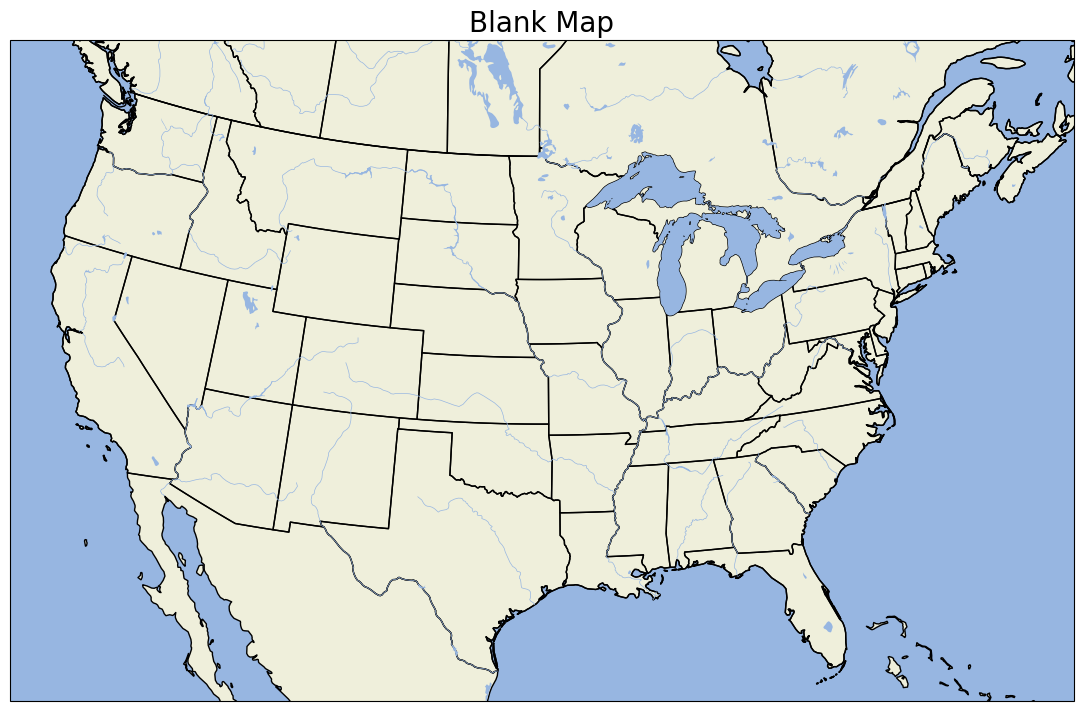

In [9]:
#define coordinate system and projection - specify ccrs so data knows where to be plotted
proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=35)
crs = ccrs.LambertConformal

#create figure and axes (subplots #, #, # is amount of dimensions in dataset)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7), subplot_kw=dict(projection=proj),
                       layout='constrained')

# Add various map elements
ax.add_feature(cfeature.COASTLINE.with_scale("50m"), lw=1) #lw is line width
ax.add_feature(cfeature.STATES.with_scale("50m"), lw=1)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.RIVERS, lw=0.5)

# Set plot bounds
ax.set_extent((-120, -70, 22, 52))

#set title, call plot
plt.title('Blank Map', fontsize=20)
plt.show() #this should be the final line of code in this cell. 

### Add Data to the Blank Map

The date format entered in `desired_time` is simplified by using `strftime` to format the date to match the formatting in the time index. By using `strftime`, we don't have to type out exactly what is stated in the time index of the dataset. The full strftime documentation is linked [here](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-format-codes) and a companion cheatsheet is available [here](https://strftime.org). <br>

The datetime entry format used for `desired_time` is YYYY, M, DD, HH. This can be edited to look at other dates/times within the loaded dataset. When the cell is ran, we can see that the `desired_time` output matches the time index in our dataset. <br>
<br>

In [13]:
#select time from dataset
desired_time = datetime(2016, 4, 16, 18).strftime('%Y-%m-%dT%H:%M') #(year, month, day, UTC hour)
desired_time

'2016-04-16T18:00'

Unnecessary cfeatures are commented out by selecting the code lines and pressing `control` + `/` .

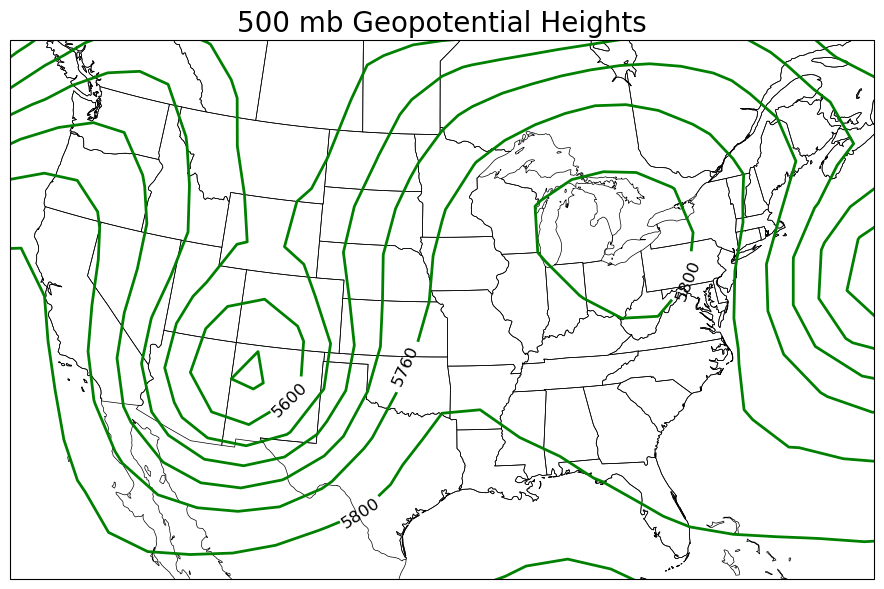

In [12]:
#create 2D meshgrid
lon, lat = np.meshgrid(data_d.lon, data_d.lat)

#create new dataset from chosen time
time_slice = data_d.sel(time=desired_time)

#assign datapoints for plotting
x = time_slice.lon
y = time_slice.lat
z = time_slice.GPH

#define coordinate system and projection - specify ccrs so data knows where to be plotted
proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=35, standard_parallels=[35])
transform = ccrs.PlateCarree()

# #create figure and axes (subplots #, #, # is amount of dimensions in dataset)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7), subplot_kw=dict(projection=proj))

# Add various map elements
ax.add_feature(cfeature.COASTLINE.with_scale("50m"), lw=0.5) #lw is line width
ax.add_feature(cfeature.STATES.with_scale("50m"), lw=0.5)
# ax.add_feature(cfeature.BORDERS)
# ax.add_feature(cfeature.OCEAN)
# ax.add_feature(cfeature.LAKES)
# ax.add_feature(cfeature.LAND)
# ax.add_feature(cfeature.RIVERS, lw=0.5)

# Set plot bounds
ax.set_extent((-120, -70, 22, 52))

#plot contour
cs = ax.contour(x, y, z, transform=transform, colors='green', linewidths=2, linestyles='solid', levels=30)
        #levels determines how many contours to display

#add contour labels
ax.clabel(cs, fontsize=12, colors='k', inline=1, inline_spacing=8,
          fmt='%i', rightside_up=True, use_clabeltext=True)

plt.title('500 mb Geopotential Heights', fontsize=20)
plt.show() #this should be the final line of code in this cell. 

### Let's unpack some things we added to the previous code

`lat, lon = np.meshgrid(data_d.lat, data_d.lon)`

> The [np.meshgrid](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html) function creates a N-D grid from 1D arrays it is fed. The value of N is the number of 1D arrays it is fed. <br>
<br>
> Looking at the dataset below, the coordinate dimensions are indicated by the yellow box. Lat and lon are both 1D, so they can be used with np.meshgrid to create a a 2D grid. This is needed so Matplotlib and Cartopy can understand where to plot the data. 
<br>


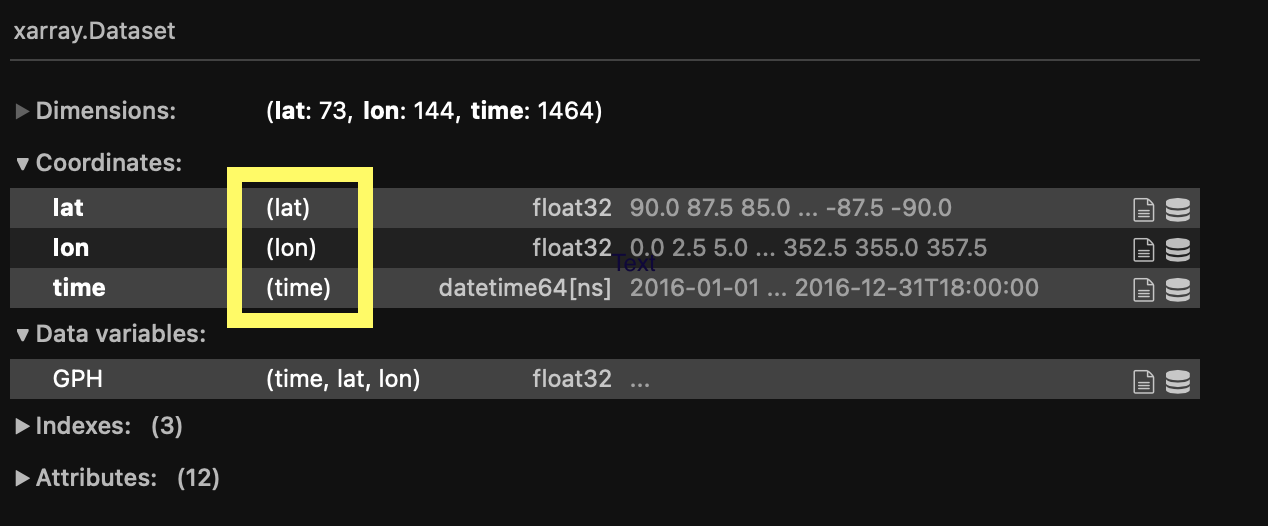

`ax.contour(x, y, z, transform=transform, colors='green', linewidths=2, linestyles='solid', levels=30)`

> This line is what creates our contours. <br>
<br>
The [contour documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.contour.html#matplotlib.axes.Axes.contour) has further information on parameters and keywords (*kwargs) available to customize the contours (linewidth, line style, color, frequency, etc.).
<br>
<br>Matplotlib also has extensive information on [choosing colors](https://matplotlib.org/stable/tutorials/colors/colormaps.html) including a list of [colorblind friendly resources](https://matplotlib.org/stable/tutorials/colors/colormaps.html#color-vision-deficiencies). 
<br>

`ax.clabel(cs, fontsize=12, colors='k', inline=1, inline_spacing=8, fmt='%i', rightside_up=True, use_clabeltext=True)`

> This line adds labels to our contours and formats them. <br>
<br>
The [clabel documentation](https://matplotlib.org/stable/api/contour_api.html#matplotlib.contour.ContourLabeler.clabel) has further information on parameters and keywords (*kwargs) available to customize the labels (inline, fmt, etc.). <br>




---

## Summary
Congratulations! You made it to the end of this cookbook. We covered opening data Reanalysis II data from TDS with OPeNDAP and visualizing it with a basic map. 

The workflow from this cookbook can be applied to most datasets with an OPeNDAP URL available. The map we created can be used as a starting point to plot many different variables and expanded globally. 

I hope you found this cookbook useful. If you have any questions, feedback, or want to share what you created, I would love to hear from you! You can find me on [Github](https://github.com/erin6541) or via email at erin6541@yahoo.com.


## Resources and References
<br>

 >[NCEP/DOE Reanalysis II Data](https://psl.noaa.gov/data/gridded/data.ncep.reanalysis2.html) <br>
 [Xarray Documentation](https://docs.xarray.dev/en/stable/) <br>
 [Matplotlib Documentation](https://matplotlib.org) <br>
 [Cartopy Documentation](https://scitools.org.uk/cartopy/docs/latest/#)<br>
 [Unidata Python Resources](https://unidata.github.io/python-training/)<br>
